In [1]:
!hostname

gnode011.cluster


In [2]:
!nvidia-smi

Wed Jun 28 17:55:45 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 520.61.05    Driver Version: 520.61.05    CUDA Version: 11.8     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100 80G...  Off  | 00000000:31:00.0 Off |                    0 |
| N/A   33C    P0    62W / 300W |      0MiB / 81920MiB |     23%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [3]:
import itertools as it
import pickle
import torch
import torch.nn as nn
import torch.optim as optim
import torch.fft
import torch.nn.functional as F
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sdeint
from toolbox import (
    make_loss,
    StatLoss,
    SINN,
    FPU
)

In [4]:
torch.cuda.is_available()

True

In [5]:
device = torch.device('cuda')

In [6]:
print(torch.__version__)
print(torch.version.cuda)

1.13.0+cu117
11.7


200.0
(1500, 400) (1500, 400)
(400, 400) (400, 400) (400, 400)
(400, 400, 2)
CPU times: user 2.4 s, sys: 26.8 ms, total: 2.43 s
Wall time: 2.55 s


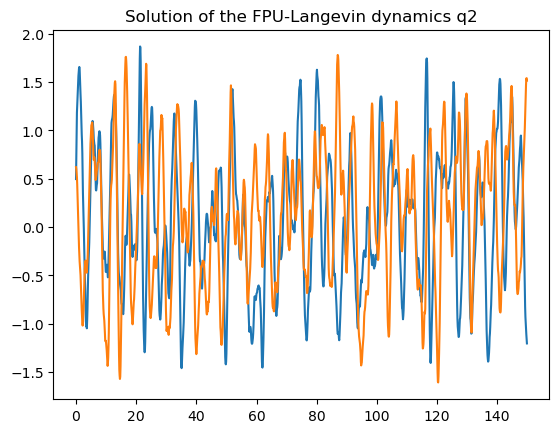

In [7]:
%%time

#### Generating SINN training data by solving SDE (Langevin dynamics)
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
from scipy.integrate import quad


def V_FPU(x,U0,x0):
    v=U0/x0**4*x**3+U0/x0**2*x      # FPU potential 
    return v


#### Parameters 
gamma = 1                              # coupling constant 
beta = 1                               # Inverse temperature, i.e. T=1/beta
dt = 0.01                              # Step-size of the SDE solver 
delta_t = 0.1                          # Step-size of the temporally coarse-grained path
batch = 400                            # Batch size 
sec_length = 400                       # Length of the input sequence 
U0 = 1                                 # FPU parameter, depth of the well 
x0 = 1                                 # FPU parameter, position of the basin 
rho = 0.10                            # Correlation of q1 and q2 

#### SDE solver (EM scheme) 
Time = 5*delta_t*sec_length
print(Time)
length=int(Time/dt)+1
t = np.linspace(0,Time,length) # define time axis
gap=int(delta_t/dt)
t_store=t[0:-1:gap]
q1_store = np.zeros([t_store.size+1,batch])
q2_store = np.zeros([t_store.size+1,batch])
# q_store = np.zeros([t_store.size+1,batch])
p1=np.zeros((2,batch))
p2=np.zeros((2,batch))
q1=np.zeros((2,batch))
q2=np.zeros((2,batch))

# solve SDE
j=1
for i in range(1,length):
     q1[1,:] = q1[0,:] + p1[0,:]*dt
     p1[1,:] = p1[0,:] + (-V_FPU(q1[0,:],U0,x0)-gamma*p1[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     q2[1,:] = q2[0,:] + p2[0,:]*dt
     p2[1,:] = p2[0,:] + (-V_FPU(q2[0,:],U0,x0)-gamma*p2[0,:])*dt + np.random.randn(1,batch)*np.sqrt(2*dt*gamma/beta)
     if i % gap ==0:            
            q1_store[j,:]=q1[1,:]
            q2_store[j,:]=rho*q1[1,:]+np.sqrt(1-rho**2)*q2[1,:]
            j=j+1
     p1[0,:]=p1[1,:]
     q1[0,:]=q1[1,:]
     p2[0,:]=p2[1,:]
     q2[0,:]=q2[1,:]

Toss=int(t_store.size/4)         
q1_store=q1_store[Toss:-1,:]         
q2_store=q2_store[Toss:-1,:]    
print(q1_store.shape,q2_store.shape)



plt.figure(0)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q1")
# plt.savefig("figs/FPU_dt016.pdf", dpi=150)

plt.figure(1)
for i in range(2):
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,i])
plt.title("Solution of the FPU-Langevin dynamics q2")

# Construct the sample traj for SINN learning 
ini=np.random.randn(sec_length,batch)
Traj_q1=q1_store[0:sec_length,:]
Traj_q2=q2_store[0:sec_length,:]
print(ini.shape, Traj_q1.shape, Traj_q2.shape)

Traj = np.empty((sec_length,batch,2))
Traj[:,:,0] = Traj_q1
Traj[:,:,1] = Traj_q2
T=np.arange(len(Traj_q1[:,1]))*delta_t
x=np.linspace(-5,5,sec_length)
print(Traj.shape)

# 1. 1 input

In [8]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 1), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 1]) torch.float32
The torch validation size is torch.Size([800, 400, 1]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [9]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

torch.Size([400, 2])


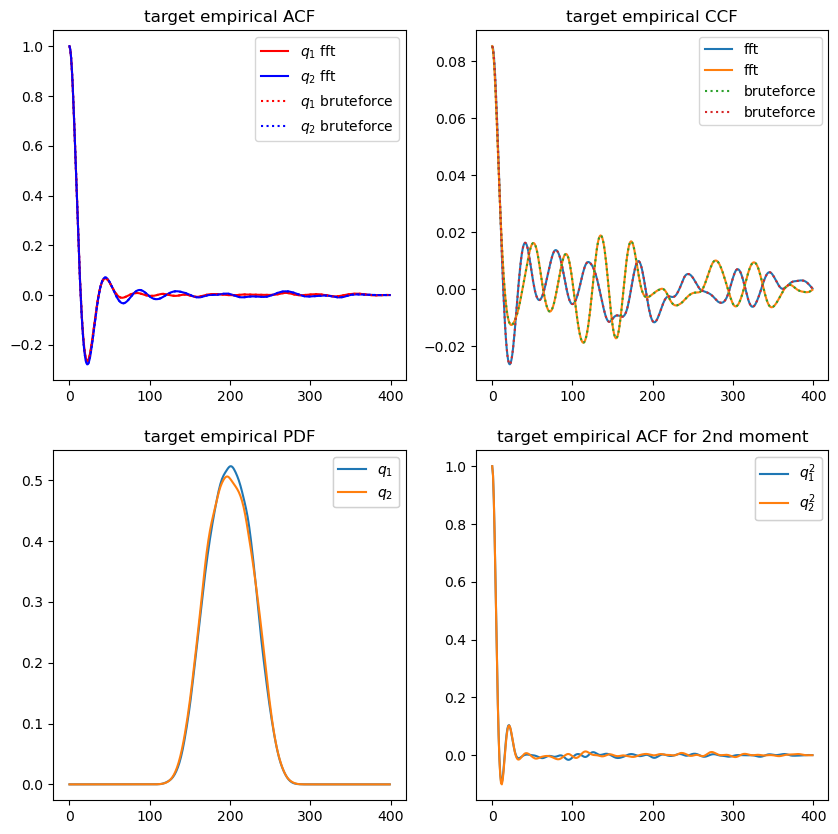

In [10]:
# Plotting target ACFs and PDF
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs[0,0].plot(loss_acf_fft._target.cpu()[...,0],'r', label=r'$q_1$ fft')
axs[0,0].plot(loss_acf_fft._target.cpu()[...,-1],'b', label=r'$q_2$ fft')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,0],'r:', label= r'$q_1$ bruteforce')
axs[0,0].plot(loss_acf_bruteforce._target.cpu()[...,1], 'b:', label=r'$q_2$ bruteforce')
axs[0,0].legend()
axs[0,0].set_title('target empirical ACF')

axs[0,1].plot(loss_ccf_fft._target.cpu()[...,1:3], label='fft')
axs[0,1].plot(loss_ccf_bruteforce._target.cpu()[...,1:3],':',label='bruteforce')
# legend2 = axs[0,1].legend(iter(bf), ('q bf', 'p bf'), loc=1)
# axs[0,1].add_artist(legend2)
axs[0,1].legend()
axs[0,1].set_title('target empirical CCF')

x_grid=-np.linspace(-5,5,num=sec_length)
pdf = axs[1,0].plot(loss_pdf_empirical._target.cpu())
legend3 = axs[1,0].legend(iter(pdf), (r'$q_1$', r'$q_2$'), loc=1)
axs[1,0].add_artist(legend3)
axs[1,0].set_title('target empirical PDF')


print(loss_acf_sec_moment._target.cpu().size())
sec_moment = axs[1,1].plot(loss_acf_sec_moment._target.cpu())
legend4 = axs[1,1].legend(iter(sec_moment), (r'$q_1^2$', r'$q_2^2$'),loc=1)
axs[1,1].set_title('target empirical ACF for 2nd moment')
axs[1,1].add_artist(legend4)

plt.show()

## 1.3. Loss function=CCF($\textbf{x}$)+PDF($\textbf{x}$)+ACF($\textbf{x}^2$)

In [11]:
### Defining SINN model
net = SINN(1, 10, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [12]:
for name, param in net.named_parameters():
    if param.requires_grad:
        print(name, param.data)

lstm.weight_ih_l0 tensor([[-0.1048],
        [-0.0543],
        [ 0.1838],
        [ 0.2501],
        [ 0.1298],
        [-0.2420],
        [-0.0761],
        [ 0.2923],
        [-0.0381],
        [-0.2707],
        [ 0.0290],
        [ 0.0403],
        [ 0.1999],
        [-0.0916],
        [-0.2331],
        [ 0.0290],
        [ 0.0934],
        [ 0.1795],
        [-0.2627],
        [ 0.2361],
        [ 0.2567],
        [ 0.1713],
        [-0.0472],
        [-0.1077],
        [-0.2463],
        [-0.0977],
        [ 0.3154],
        [-0.1073],
        [ 0.0083],
        [-0.0900],
        [-0.3092],
        [-0.0773],
        [ 0.2574],
        [ 0.1479],
        [-0.0332],
        [-0.0406],
        [ 0.1002],
        [ 0.1829],
        [-0.2166],
        [ 0.1588]], device='cuda:0')
lstm.weight_hh_l0 tensor([[ 4.4378e-02,  4.9366e-02,  1.3182e-01,  1.1368e-01,  1.7736e-01,
          2.8976e-01, -1.0897e-01, -8.4097e-02,  1.9977e-01, -1.0506e-01],
        [-2.3280e-01, -1.3418e-01,  1

In [13]:
weight = torch.tensor([1.,0.1,1.], requires_grad=True, device='cuda:0')

In [14]:
optimizer_weight = optim.Adam([weight], lr=1e-3)

In [15]:
optimizer.param_groups

[{'params': [Parameter containing:
   tensor([[-0.1048],
           [-0.0543],
           [ 0.1838],
           [ 0.2501],
           [ 0.1298],
           [-0.2420],
           [-0.0761],
           [ 0.2923],
           [-0.0381],
           [-0.2707],
           [ 0.0290],
           [ 0.0403],
           [ 0.1999],
           [-0.0916],
           [-0.2331],
           [ 0.0290],
           [ 0.0934],
           [ 0.1795],
           [-0.2627],
           [ 0.2361],
           [ 0.2567],
           [ 0.1713],
           [-0.0472],
           [-0.1077],
           [-0.2463],
           [-0.0977],
           [ 0.3154],
           [-0.1073],
           [ 0.0083],
           [-0.0900],
           [-0.3092],
           [-0.0773],
           [ 0.2574],
           [ 0.1479],
           [-0.0332],
           [-0.0406],
           [ 0.1002],
           [ 0.1829],
           [-0.2166],
           [ 0.1588]], device='cuda:0', requires_grad=True),
   Parameter containing:
   tensor([[ 4.4378e-

In [16]:
optimizer_weight.param_groups

[{'params': [tensor([1.0000, 0.1000, 1.0000], device='cuda:0', requires_grad=True)],
  'lr': 0.001,
  'betas': (0.9, 0.999),
  'eps': 1e-08,
  'weight_decay': 0,
  'amsgrad': False,
  'maximize': False,
  'foreach': None,
  'capturable': False,
  'differentiable': False,
  'fused': False}]

In [17]:
class MultipleOptimizer(object):
    def __init__(self,*op):
        self.optimizers = op

    def zero_grad(self):
        for op in self.optimizers:
            op.zero_grad()

    def step(self):
        for op in self.optimizers:
            op.step()

In [18]:
opt = MultipleOptimizer(optimizer, optimizer_weight)

In [19]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(5000):
    opt.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = 1/(2*weight.data[0]**2) * loss_ccf_fft(prediction) + 1/(2*weight.data[1]**2) * loss_pdf_empirical(prediction) + 1/(2*weight.data[2]**2) * loss_acf_sec_moment(prediction**2) + torch.sum(torch.log(weight))
    Terr = loss_ccf_fft(prediction)+loss_pdf_empirical(prediction)+ loss_acf_sec_moment(prediction**2)
    loss.backward()
    opt.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val_vec = torch.tensor([loss_ccf_bruteforce(pred_val),loss_pdf_empirical(pred_val),loss_acf_sec_moment(pred_val**2)], requires_grad=True, device='cuda:0')
            loss_val = torch.matmul(torch.reciprocal(2*torch.square(weight)),loss_val_vec)+torch.sum(torch.log(weight))
            Verr = torch.sum(loss_val_vec)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, Terr, Verr, ccf, pdf, acf_sec_moment))
            print(torch.reciprocal(2*torch.square(weight)))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(Terr.detach().cpu().numpy())
            V_error.append(Verr.detach().cpu().numpy())
            Step.append(step)
#     if ccf <=0.0000 and pdf<=0.001 and acf_sec_moment<=0.001:
#             break

# if ccf > 0.001 or pdf >0.001 or acf_sec_moment>0.001:
#     print ('Training failed')

print('Training finished')


[0]-th step loss: 0.2556, 0.2543, ccf: 0.00545, pdf: 0.24590, acf: 0.00293
tensor([ 0.5010, 51.0152,  0.5010], device='cuda:0')
[50]-th step loss: 0.1900, 0.1851, ccf: 0.00785, pdf: 0.17607, acf: 0.00116
tensor([  0.5556, 248.1858,   0.5556], device='cuda:0')
[100]-th step loss: 0.0661, 0.0703, ccf: 0.01940, pdf: 0.04292, acf: 0.00800
tensor([6.2119e-01, 1.0451e+04, 6.2119e-01], device='cuda:0')
[150]-th step loss: 0.0950, 0.0933, ccf: 0.01992, pdf: 0.06438, acf: 0.00905
tensor([7.0156e-01, 8.3632e+03, 7.0156e-01], device='cuda:0')
[200]-th step loss: 0.0789, 0.0752, ccf: 0.01833, pdf: 0.04941, acf: 0.00748
tensor([8.0190e-01, 1.8603e+04, 8.0190e-01], device='cuda:0')
[250]-th step loss: 0.0256, 0.0242, ccf: 0.01172, pdf: 0.01119, acf: 0.00127
tensor([9.3003e-01, 1.5884e+06, 9.3003e-01], device='cuda:0')
[300]-th step loss: 0.0324, 0.0318, ccf: 0.01286, pdf: 0.01658, acf: 0.00239
tensor([1.0983e+00, 1.9727e+05, 1.0983e+00], device='cuda:0')
[350]-th step loss: 0.0678, 0.0669, ccf: 0.00

[2950]-th step loss: 0.0108, 0.0108, ccf: 0.00806, pdf: 0.00168, acf: 0.00106
tensor([13385.4961,  2379.4832, 13385.4961], device='cuda:0')
[3000]-th step loss: 0.0108, 0.0124, ccf: 0.00808, pdf: 0.00347, acf: 0.00088
tensor([52635.1758,  2724.8645, 52635.1758], device='cuda:0')
[3050]-th step loss: 0.0886, 0.0884, ccf: 0.00849, pdf: 0.07832, acf: 0.00160
tensor([ 526.5829, 3200.7627,  526.5829], device='cuda:0')
[3100]-th step loss: 0.0887, 0.0891, ccf: 0.00850, pdf: 0.07897, acf: 0.00160
tensor([ 521.7773, 3897.3328,  521.7773], device='cuda:0')
[3150]-th step loss: 0.0899, 0.0891, ccf: 0.00850, pdf: 0.07897, acf: 0.00160
tensor([ 521.9294, 5011.6807,  521.9294], device='cuda:0')
[3200]-th step loss: 0.0901, 0.0891, ccf: 0.00850, pdf: 0.07897, acf: 0.00160
tensor([ 522.1124, 7070.8369,  522.1124], device='cuda:0')
[3250]-th step loss: 0.0893, 0.0891, ccf: 0.00849, pdf: 0.07897, acf: 0.00160
tensor([  522.3002, 12093.1318,   522.3002], device='cuda:0')
[3300]-th step loss: 0.0902, 0.0

In [20]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.plot(Step, T_error,'r',label='Training error')
plt.plot(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

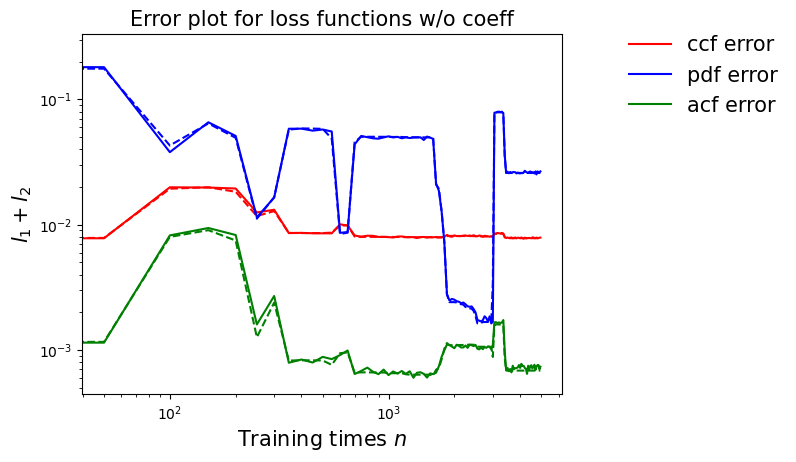

In [21]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
# plt.loglog(Step, T_error,'k',label='Training error')
# plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

## Test 1: plot the sample path generated by SINN and the exact sample path 

In [61]:
def test1(Traj, T, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    # Test 1: plot the sample path generated by SINN and the exact sample path 
    skip = 0

    fig = plt.figure(0)
    plt.title("MD trajectories",fontsize=15) 
    plt.plot(T[skip:]-T[skip], Traj[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15) 


    fig = plt.figure(1)
    plt.title("SINN trajectories",fontsize=15)    
    plt.plot(T[skip:]-T[skip], prediction[skip:, 0])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$ and $q_2(t)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

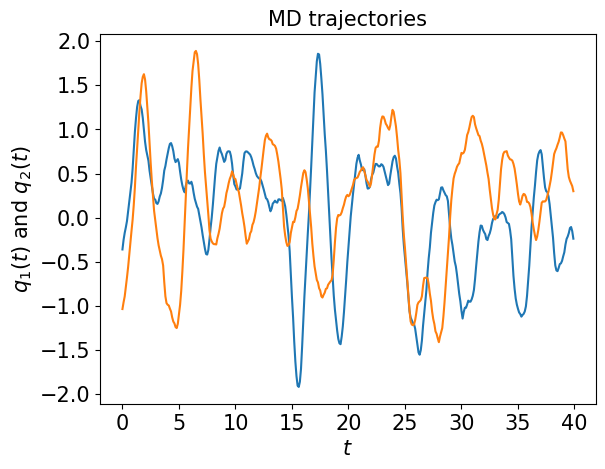

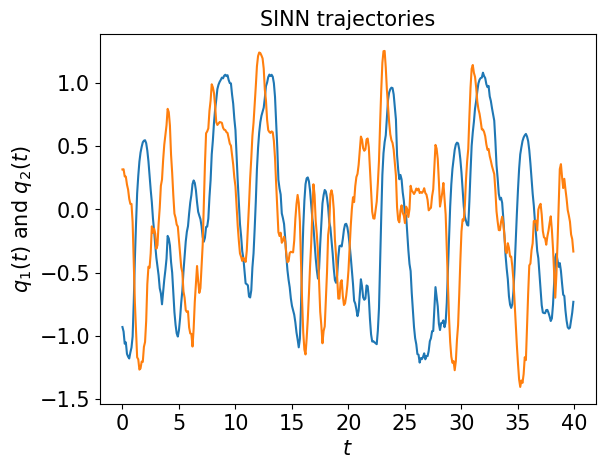

In [62]:
test1(Traj, T, net)

## Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF

In [63]:
def test2(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 2: plot the CCF of the sample path generated by the SINN and the exact CCF  
    ccf_p=StatLoss.ccf(Pred[-sec_length:,:,:])
    ccf_t=StatLoss.ccf(target)
    corr_p=ccf_p.detach().cpu().numpy()
    corr_t=ccf_t.detach().cpu().numpy()
    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_1$',fontsize=15)    
    plt.plot(T, corr_t[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_2$',fontsize=15)          
    plt.plot(T, corr_t[...,-1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, corr_p[...,-1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized CCF',fontsize=15)    
    plt.plot(T, corr_t[...,1:3],'r')        # correlation function of the target 
    plt.plot(T, corr_p[...,1:3], 'b--')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])

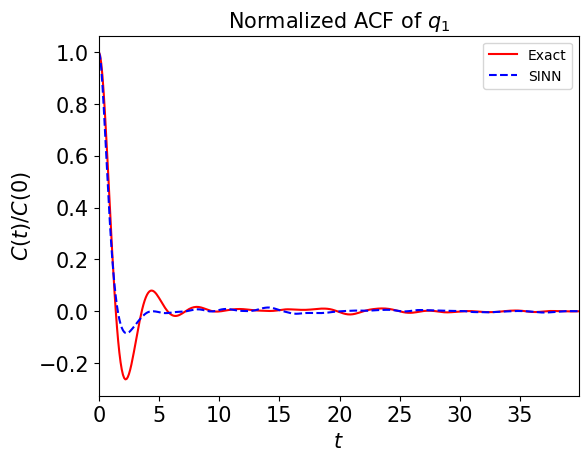

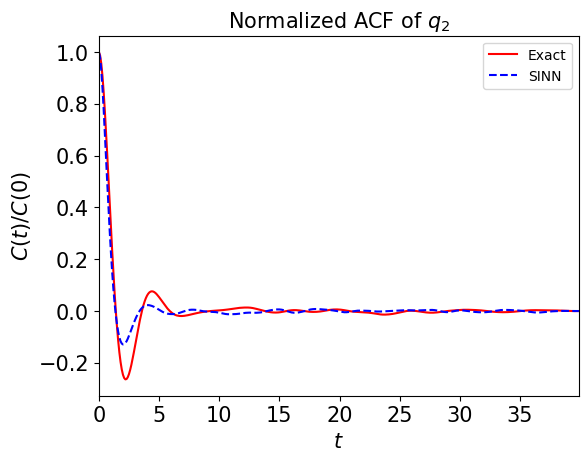

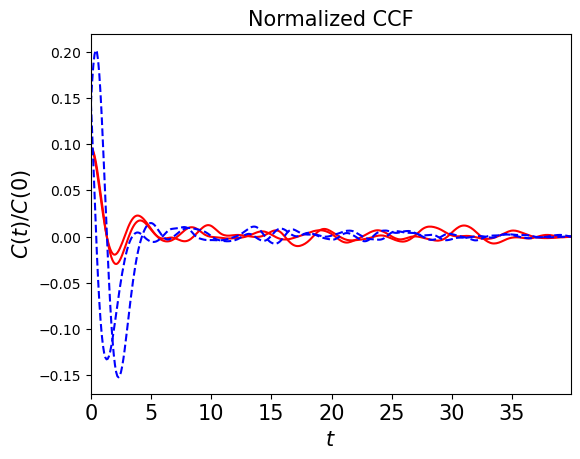

In [64]:
test2(target, net)

## Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  

In [65]:
def test3(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    
    # Test 3: plot the PDF of the sample path generated by SINN and the exact PDF  
    rho_data =  StatLoss.gauss_kde(target, -5, 5, 100,None).cpu()
    rho_input = StatLoss.gauss_kde(ran_input, -5, 5, 100,None).cpu()
    rho_prediction = StatLoss.gauss_kde(Pred[-sec_length:,:,:].detach(), -5, 5, 100,None).cpu()


    x=np.linspace(-5, 5, 100)
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r"Equilibrium probability density function",fontsize=15)    
    plt.plot(x, rho_data.numpy()[...,0],label=r'Exact PDF of $q_1$')    # target PDF
    plt.plot(x, rho_data.numpy()[...,1],label=r'Exact PDF of $q_2$')    # target PDF
    plt.plot(x, rho_input.numpy(), 'b--', label=r'PDF of the input')     # PDF of the input
    plt.plot(x, rho_prediction.numpy()[...,0], ':',label=r'PDF of the output $q_1$')  # PDF after the training 
    plt.plot(x, rho_prediction.numpy()[...,1], ':',label=r'PDF of the output $q_2$')  # PDF after the training 
    plt.xlim(-5,5)
    plt.ylim(0,0.6)
    plt.xlabel(r'$x$',fontsize=15)
    plt.ylabel(r'$\rho(x)$',fontsize=15)
    plt.legend(frameon=False,fontsize=10)
    plt.xticks(fontsize=15)
    plt.yticks(fontsize=15)

In [66]:
test3(target, net)

## Test 4: Comparing the higher-order ACF

In [67]:
def test4(target, net):
    ran_input=torch.randn(input.size(),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred,_= net(ran_input)
    prediction=Pred[-sec_length:,:,:].detach().cpu().numpy().reshape(sec_length, batch, 2)
    
    # Test 4: Comparing the higher-order ACF
    acf2=StatLoss.acf(target**2)
    pred_norm=torch.from_numpy((prediction).reshape(sec_length, batch,2))
    acf2_app=StatLoss.acf(pred_norm**2)

    
    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_1^2$',fontsize=15)    
    plt.plot(T, acf2.detach().cpu().numpy()[...,0],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,0], 'b--',label='SINN')        # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()
    
    fig = plt.figure(1)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title(r'Normalized ACF of $q_2^2$',fontsize=15)          
    plt.plot(T, acf2.detach().cpu().numpy()[...,1],'r',label='Exact')        # correlation function of the target 
    plt.plot(T, acf2_app.detach().cpu().numpy()[...,1], 'b--',label='SINN')     # Correlation function after the training      # Correlation function after the training 
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$C(t)/C(0)$',fontsize=15)
    plt.xticks(fontsize=15)
    plt.xlim(0,T[-1])
    plt.yticks([-0.2,0,0.2,0.4,0.6,0.8,1.0],fontsize=15)
    plt.legend()    
    
    
    
    
    


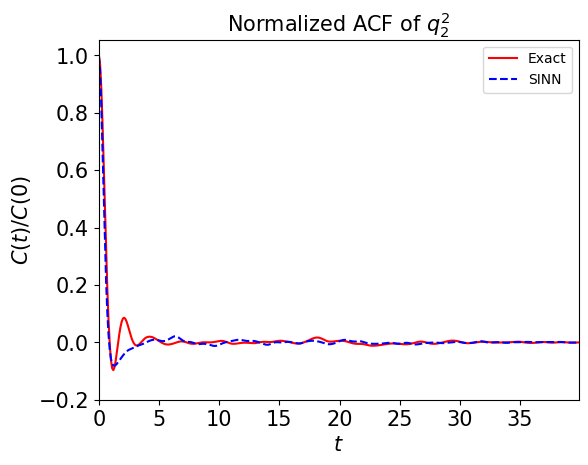

In [68]:
test4(target, net)

## Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 

In [69]:
def test5(q1_store, q2_store, net):
    # Test 5: plot the expolation result, i.e. Prediction of the FPU-Langevin dynamics for longer time 
    [a,b,c]=input.size()
    skip=20
    scale=10
    burnin=3
    fold=800
    batch_new=50
    ran_input=torch.randn(((scale-burnin)*a,batch_new,c),dtype=input.dtype,layout=input.layout, device=input.device)
    Pred_L, _= net(ran_input)
    prediction_ext=Pred_L.detach().cpu().numpy().reshape((scale-burnin)*a, batch_new,2)
    ccf_p=StatLoss.ccf(Pred_L,method='bruteforce')

    LT=np.linspace(0,(scale-burnin)*a*delta_t,num=(scale-burnin)*a+1)
    LT=LT[0:-1]


    fig = plt.figure(0)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q1_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 0],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_1(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

    fig = plt.figure(2)
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Short-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,80])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)



    fig = plt.figure(figsize=(16, 4))
    ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
    plt.title("Long-time trajectories",fontsize=15)
    plt.plot(t_store[Toss:]-t_store[Toss],q2_store[:,0],label='MD simulation')
    plt.plot(LT[skip:]-LT[skip], prediction_ext[skip:, 0, 1],'--',label='SINN simulation')
    plt.xlim([0,500])
    plt.xlabel(r'$t$',fontsize=15)
    plt.ylabel(r'$q_2(t)$',fontsize=15)
    plt.legend(frameon=False,fontsize=15)
    plt.yticks([-2,-1,0,1,2],fontsize=15)
    plt.xticks(fontsize=15)

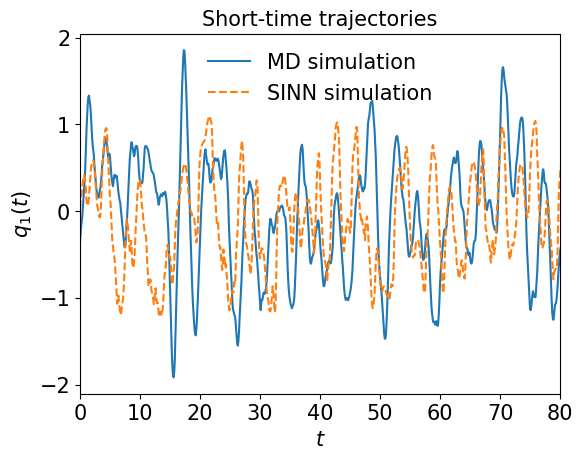

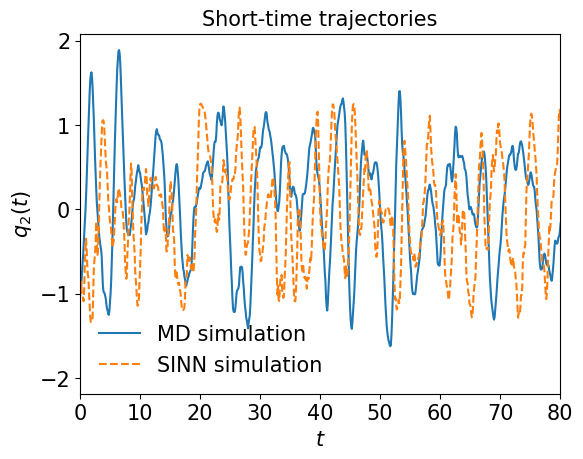

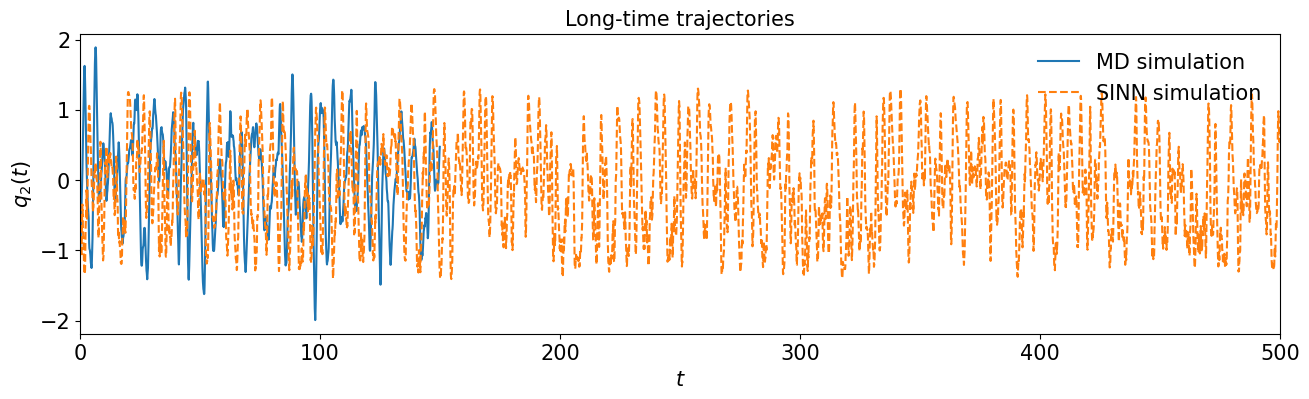

In [70]:
test5(q1_store, q2_store, net)

In [26]:
print(step)

1400


In [27]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = ccf/(ccf+pdf+acf_sec_moment)
            c2 = pdf/(ccf+pdf+acf_sec_moment)
            c3 = acf_sec_moment/(ccf+pdf+acf_sec_moment)
    if ccf <=0.0005 and pdf<=0.0005 and acf_sec_moment<=0.0005:
            break

if ccf > 0.0005 or pdf >0.0005 or acf_sec_moment>0.0005:
    print ('Training failed')

print('Training finished')
print(step)

[1400]-th step loss: 0.0007, 0.0007, ccf: 0.00080, pdf: 0.00063, acf: 0.00068
[1450]-th step loss: 0.0006, 0.0006, ccf: 0.00073, pdf: 0.00042, acf: 0.00058
[1500]-th step loss: 0.0006, 0.0005, ccf: 0.00064, pdf: 0.00040, acf: 0.00053
[1550]-th step loss: 0.0005, 0.0005, ccf: 0.00060, pdf: 0.00036, acf: 0.00049
[1600]-th step loss: 0.0005, 0.0005, ccf: 0.00057, pdf: 0.00031, acf: 0.00046
[1650]-th step loss: 0.0004, 0.0004, ccf: 0.00054, pdf: 0.00029, acf: 0.00043
[1700]-th step loss: 0.0004, 0.0004, ccf: 0.00050, pdf: 0.00027, acf: 0.00040
[1750]-th step loss: 0.0004, 0.0004, ccf: 0.00046, pdf: 0.00025, acf: 0.00038
Training finished
1750


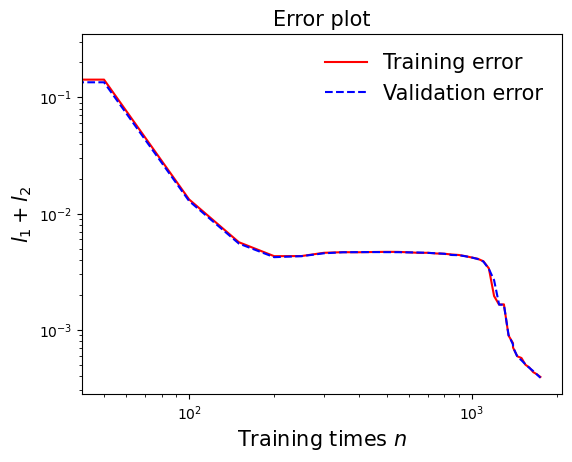

In [28]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

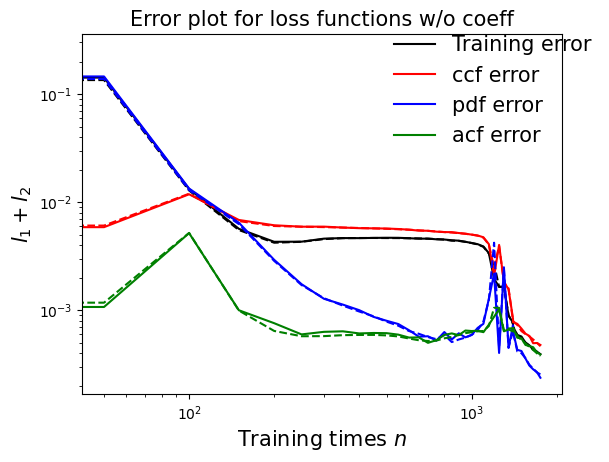

In [29]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

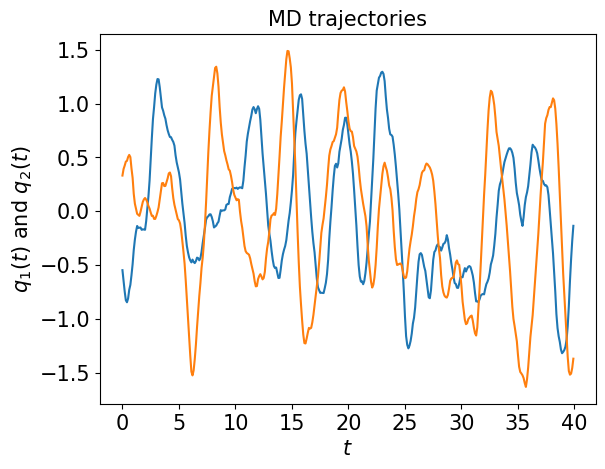

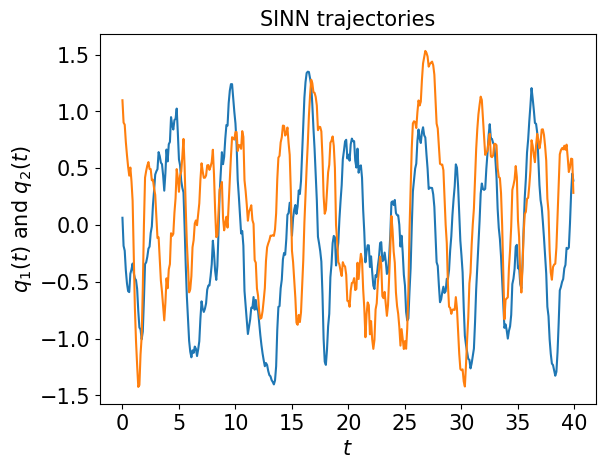

In [30]:
test1(Traj, T, net)

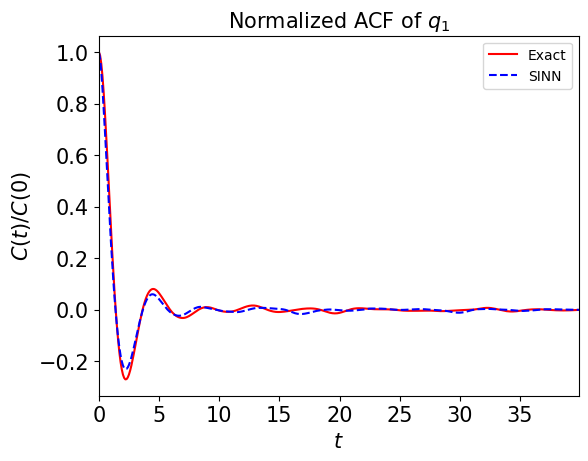

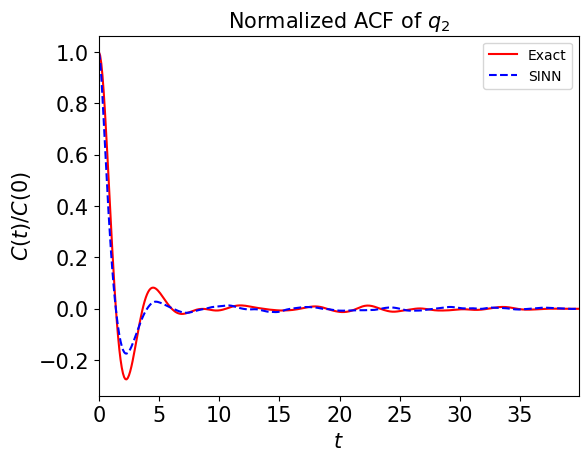

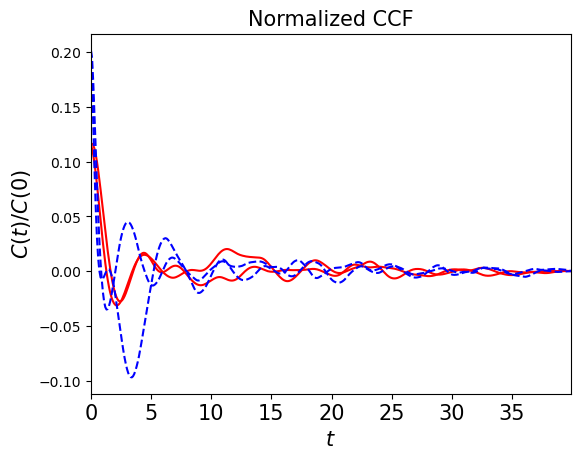

In [31]:
test2(target, net)

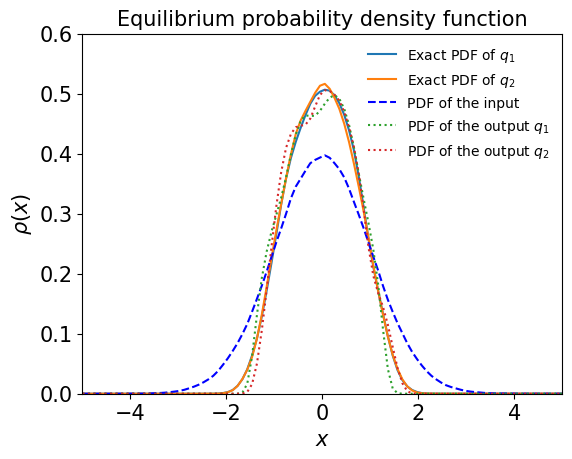

In [32]:
test3(target, net)

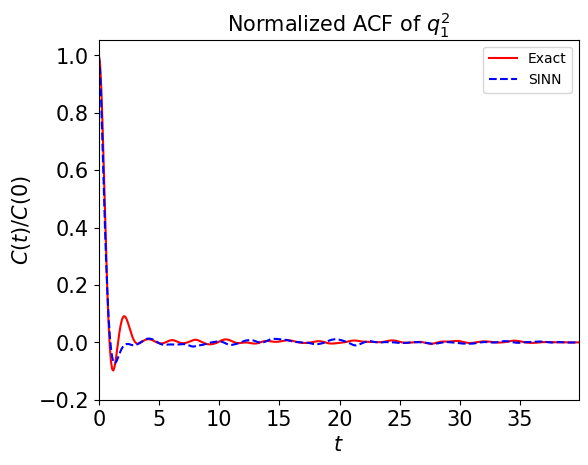

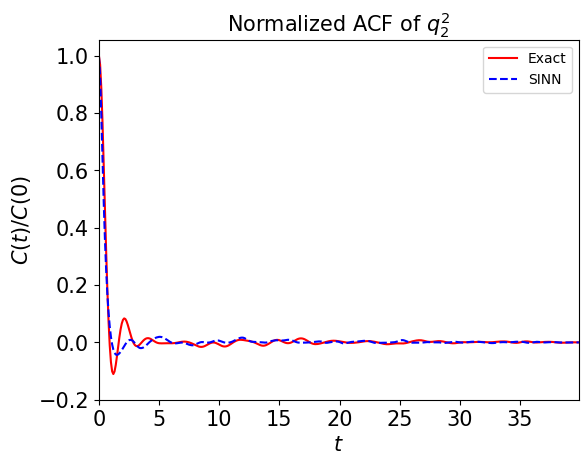

In [33]:
test4(target, net)

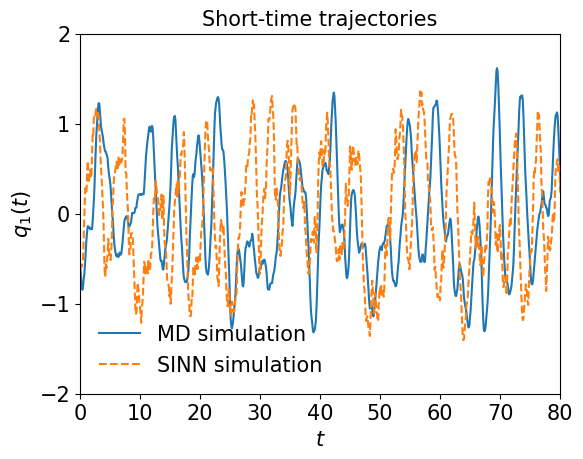

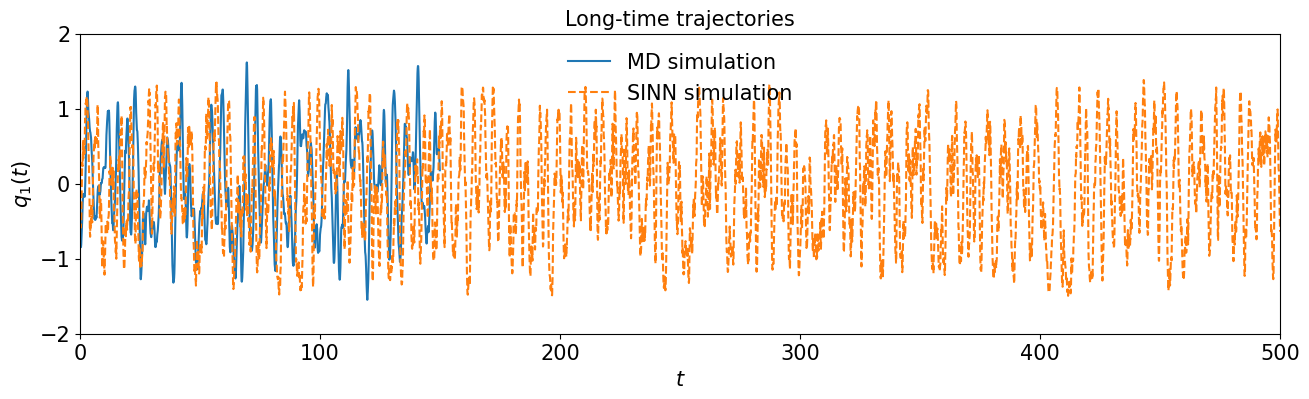

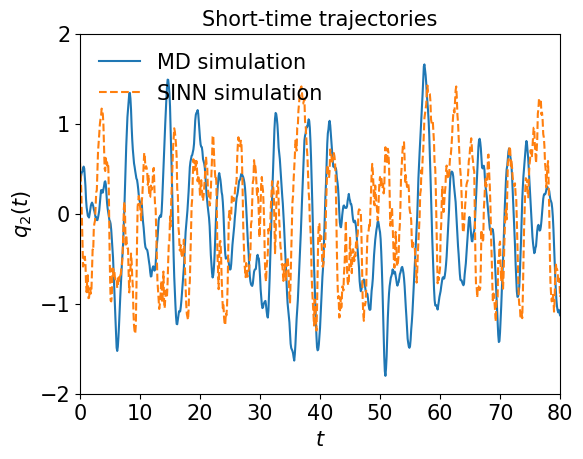

In [34]:
test5(q1_store, q2_store, net)

In [35]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = ccf/(ccf+pdf+acf_sec_moment)
            c2 = pdf/(ccf+pdf+acf_sec_moment)
            c3 = acf_sec_moment/(ccf+pdf+acf_sec_moment)
    if ccf <=0.00025 and pdf<=0.00025 and acf_sec_moment<=0.00025:
            break

if ccf > 0.00025 or pdf >0.00025 or acf_sec_moment>0.00025:
    print ('Training failed')

print('Training finished')
print(step)

[1750]-th step loss: 0.0004, 0.0004, ccf: 0.00046, pdf: 0.00026, acf: 0.00037
[1800]-th step loss: 0.0004, 0.0004, ccf: 0.00043, pdf: 0.00024, acf: 0.00035
[1850]-th step loss: 0.0003, 0.0003, ccf: 0.00040, pdf: 0.00022, acf: 0.00032
[1900]-th step loss: 0.0003, 0.0003, ccf: 0.00038, pdf: 0.00021, acf: 0.00030
[1950]-th step loss: 0.0003, 0.0003, ccf: 0.00035, pdf: 0.00019, acf: 0.00027
[2000]-th step loss: 0.0003, 0.0003, ccf: 0.00032, pdf: 0.00017, acf: 0.00025
[2050]-th step loss: 0.0002, 0.0002, ccf: 0.00030, pdf: 0.00017, acf: 0.00023
[2100]-th step loss: 0.0002, 0.0002, ccf: 0.00028, pdf: 0.00016, acf: 0.00021
[2150]-th step loss: 0.0002, 0.0002, ccf: 0.00027, pdf: 0.00014, acf: 0.00019
[2200]-th step loss: 0.0002, 0.0002, ccf: 0.00025, pdf: 0.00014, acf: 0.00018
[2250]-th step loss: 0.0002, 0.0002, ccf: 0.00024, pdf: 0.00013, acf: 0.00017
Training finished
2250


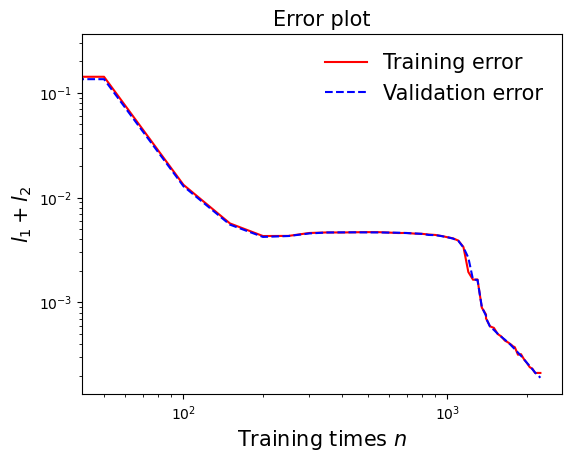

In [36]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

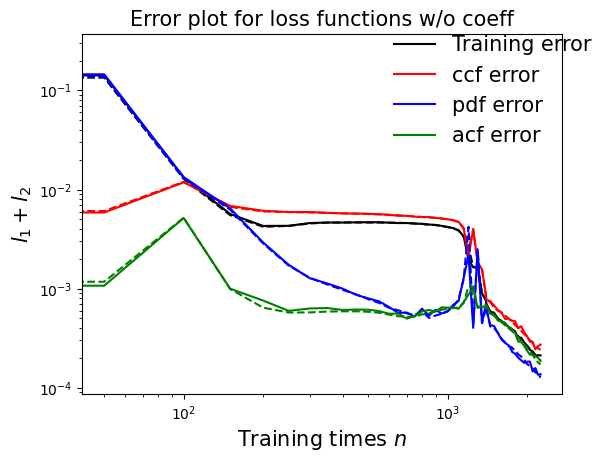

In [37]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

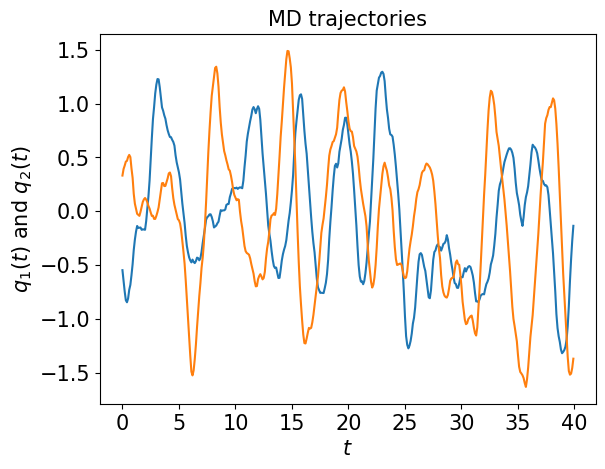

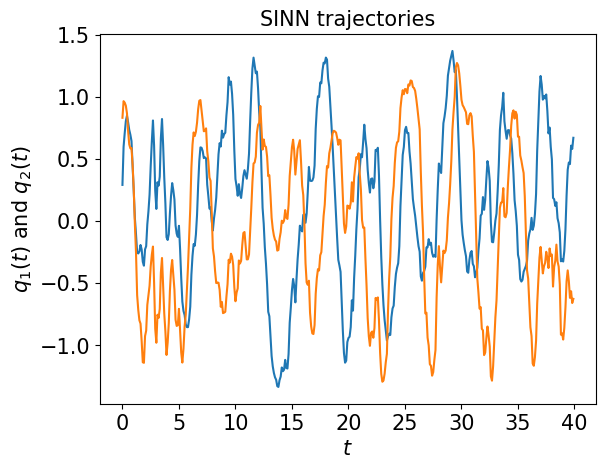

In [38]:
test1(Traj, T, net)

In [39]:
test2(target, net)

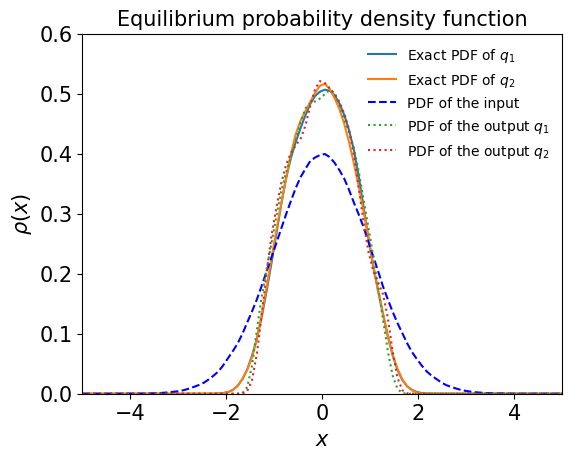

In [40]:
test3(target, net)

In [41]:
test4(target, net)

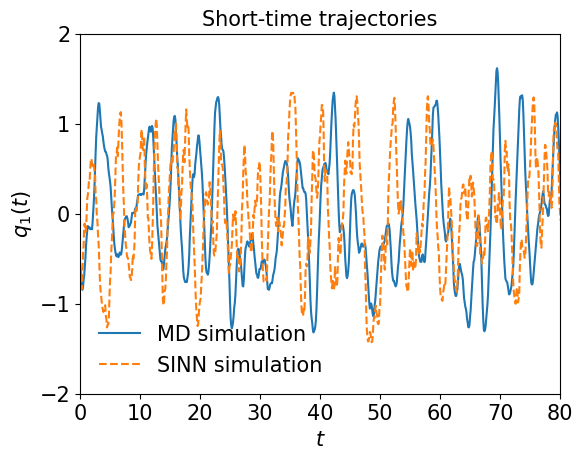

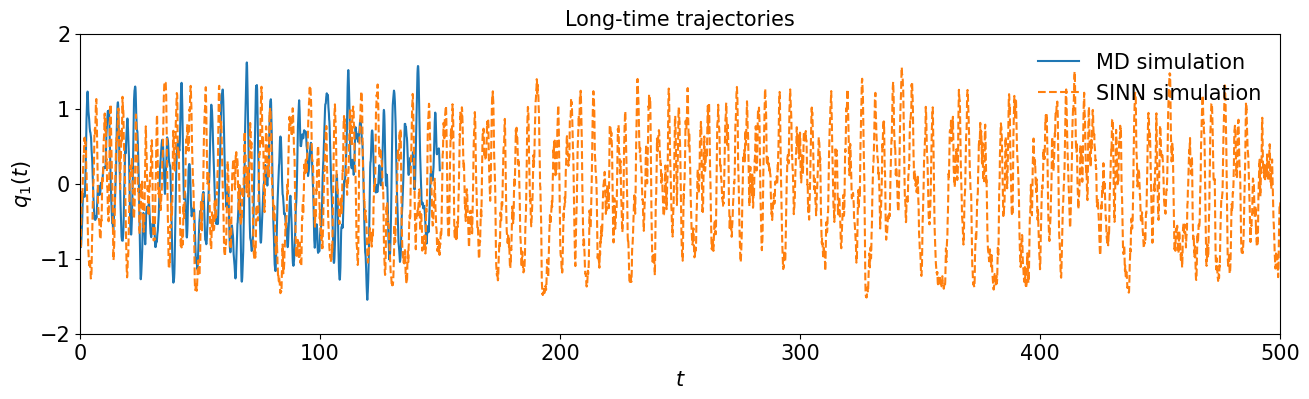

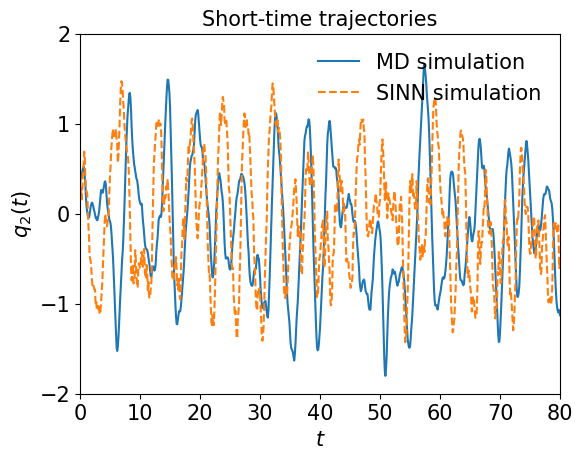

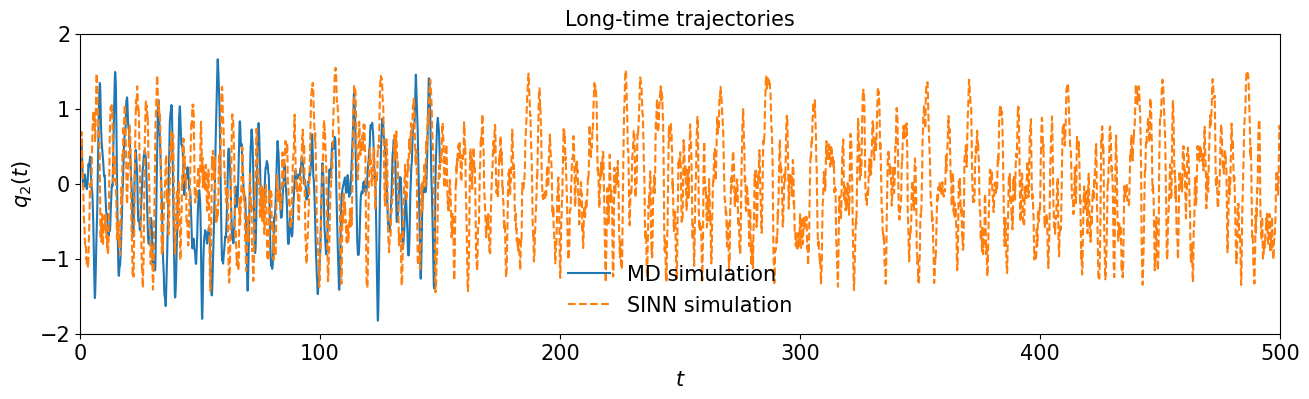

In [42]:
test5(q1_store, q2_store, net)

In [43]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = ccf/(ccf+pdf+acf_sec_moment)
            c2 = pdf/(ccf+pdf+acf_sec_moment)
            c3 = acf_sec_moment/(ccf+pdf+acf_sec_moment)
    if ccf <=0.000125 and pdf<=0.000125 and acf_sec_moment<=0.000125:
            break

if ccf > 0.000125 or pdf >0.000125 or acf_sec_moment>0.000125:
    print ('Training failed')

print('Training finished')
print(step)

[2250]-th step loss: 0.0002, 0.0002, ccf: 0.00024, pdf: 0.00013, acf: 0.00017
[2300]-th step loss: 0.0002, 0.0002, ccf: 0.00023, pdf: 0.00013, acf: 0.00016
[2350]-th step loss: 0.0002, 0.0002, ccf: 0.00022, pdf: 0.00012, acf: 0.00016
[2400]-th step loss: 0.0002, 0.0002, ccf: 0.00022, pdf: 0.00012, acf: 0.00015
[2450]-th step loss: 0.0002, 0.0002, ccf: 0.00021, pdf: 0.00010, acf: 0.00014
[2500]-th step loss: 0.0002, 0.0002, ccf: 0.00020, pdf: 0.00010, acf: 0.00014
[2550]-th step loss: 0.0001, 0.0002, ccf: 0.00019, pdf: 0.00010, acf: 0.00014
[2600]-th step loss: 0.0002, 0.0001, ccf: 0.00018, pdf: 0.00010, acf: 0.00014
[2650]-th step loss: 0.0001, 0.0001, ccf: 0.00018, pdf: 0.00010, acf: 0.00014
[2700]-th step loss: 0.0001, 0.0001, ccf: 0.00017, pdf: 0.00010, acf: 0.00014
[2750]-th step loss: 0.0001, 0.0001, ccf: 0.00018, pdf: 0.00009, acf: 0.00013
[2800]-th step loss: 0.0001, 0.0001, ccf: 0.00016, pdf: 0.00009, acf: 0.00013
[2850]-th step loss: 0.0001, 0.0001, ccf: 0.00016, pdf: 0.00009,

[7550]-th step loss: 0.0002, 0.0002, ccf: 0.00022, pdf: 0.00009, acf: 0.00012
[7600]-th step loss: 0.0001, 0.0002, ccf: 0.00021, pdf: 0.00013, acf: 0.00014
[7650]-th step loss: 0.0002, 0.0001, ccf: 0.00020, pdf: 0.00009, acf: 0.00012
[7700]-th step loss: 0.0001, 0.0002, ccf: 0.00021, pdf: 0.00008, acf: 0.00011
[7750]-th step loss: 0.0002, 0.0001, ccf: 0.00017, pdf: 0.00011, acf: 0.00013
[7800]-th step loss: 0.0001, 0.0001, ccf: 0.00019, pdf: 0.00008, acf: 0.00011
[7850]-th step loss: 0.0001, 0.0001, ccf: 0.00019, pdf: 0.00008, acf: 0.00011
[7900]-th step loss: 0.0001, 0.0001, ccf: 0.00019, pdf: 0.00007, acf: 0.00011
[7950]-th step loss: 0.0001, 0.0001, ccf: 0.00016, pdf: 0.00008, acf: 0.00011
[8000]-th step loss: 0.0001, 0.0001, ccf: 0.00015, pdf: 0.00007, acf: 0.00010
[8050]-th step loss: 0.0001, 0.0001, ccf: 0.00016, pdf: 0.00008, acf: 0.00009
[8100]-th step loss: 0.0001, 0.0001, ccf: 0.00015, pdf: 0.00007, acf: 0.00009
[8150]-th step loss: 0.0001, 0.0001, ccf: 0.00016, pdf: 0.00007,

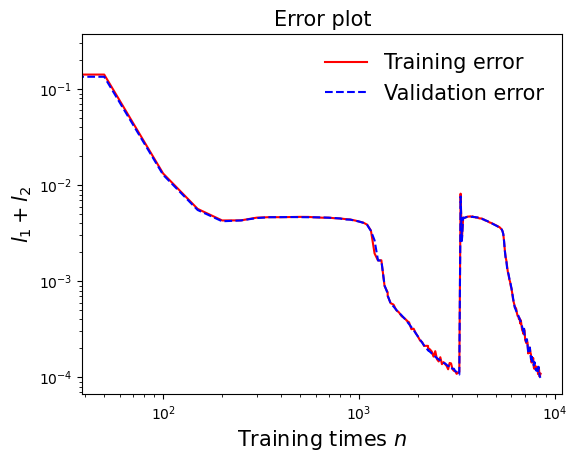

In [44]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

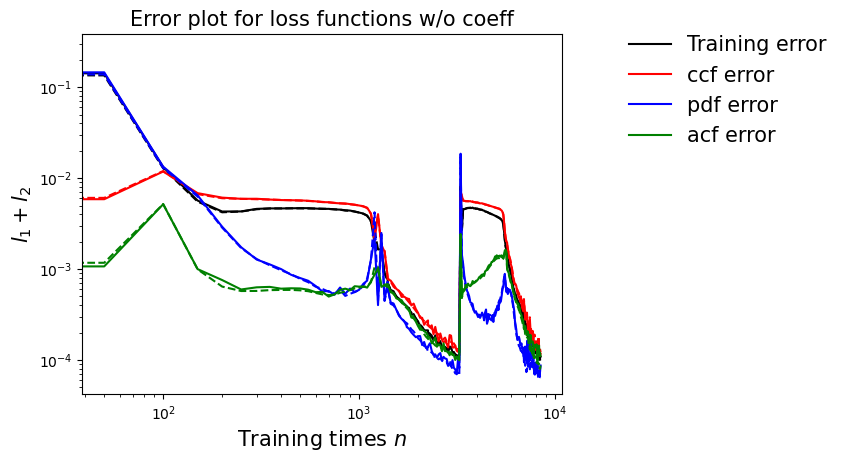

In [45]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

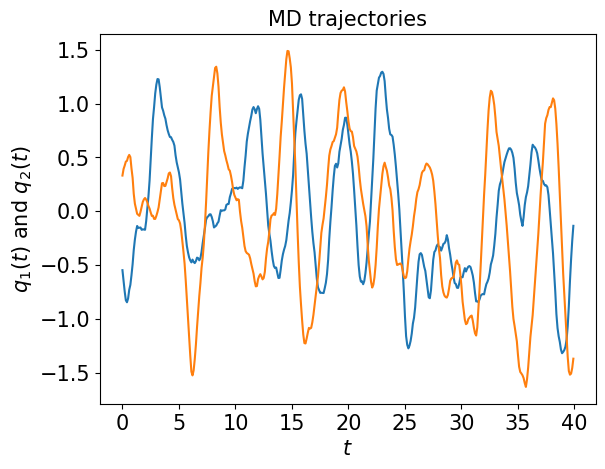

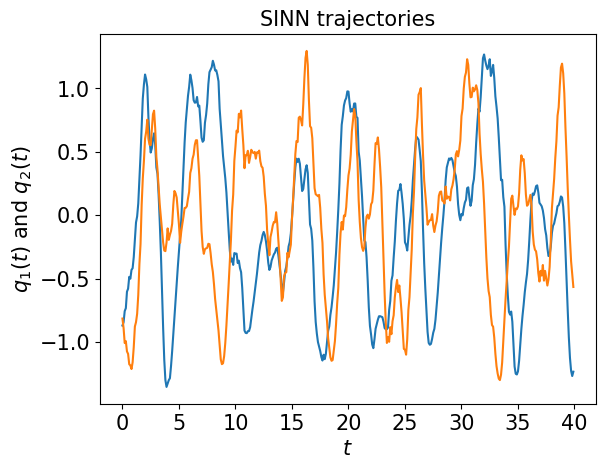

In [46]:
test1(Traj, T, net)

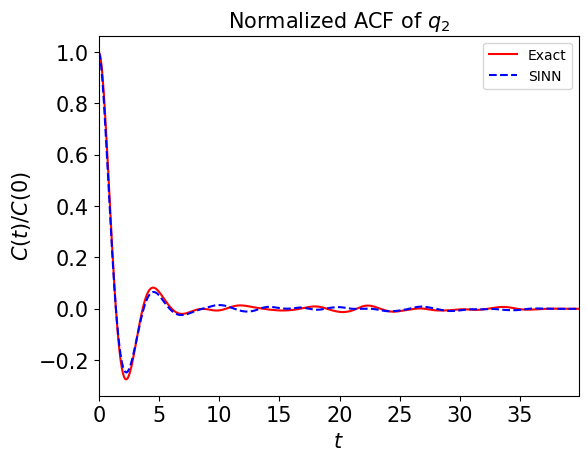

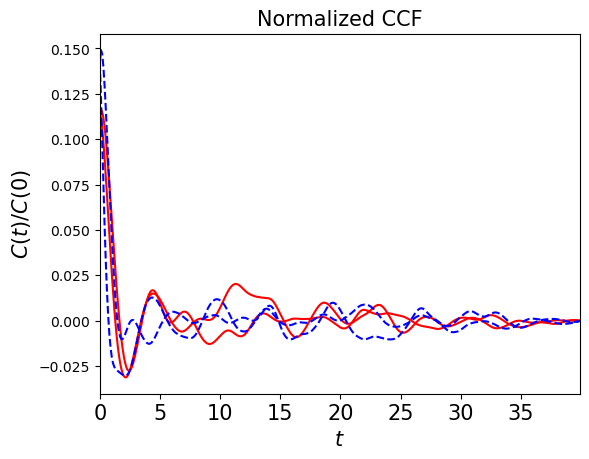

In [47]:
test2(target, net)

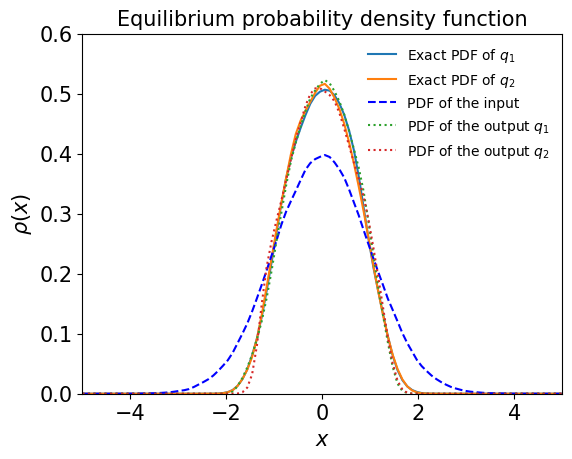

In [48]:
test3(target, net)

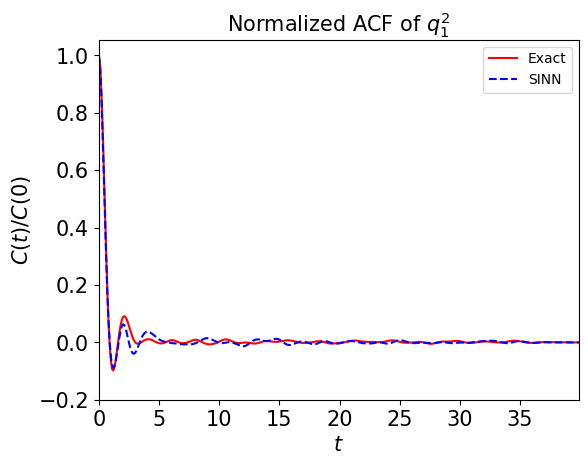

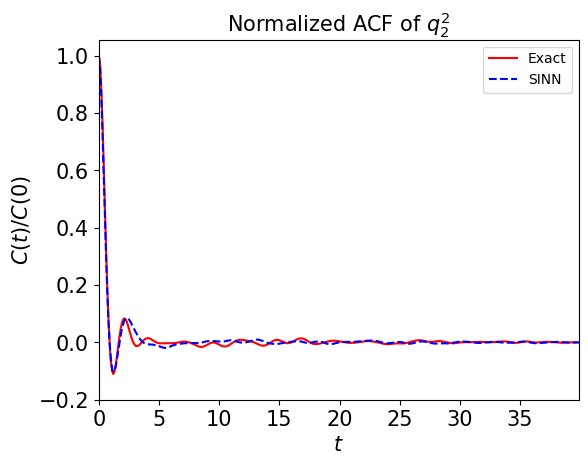

In [49]:
test4(target, net)

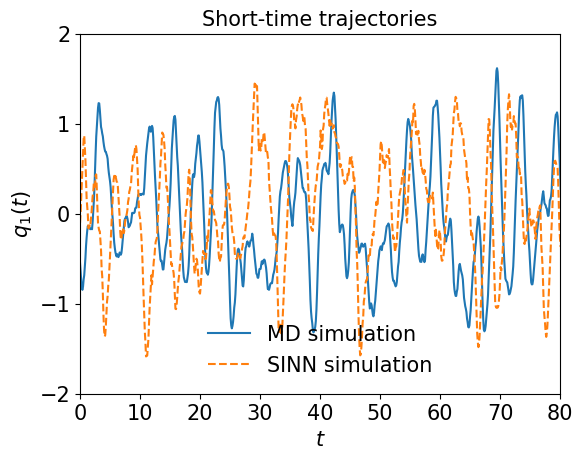

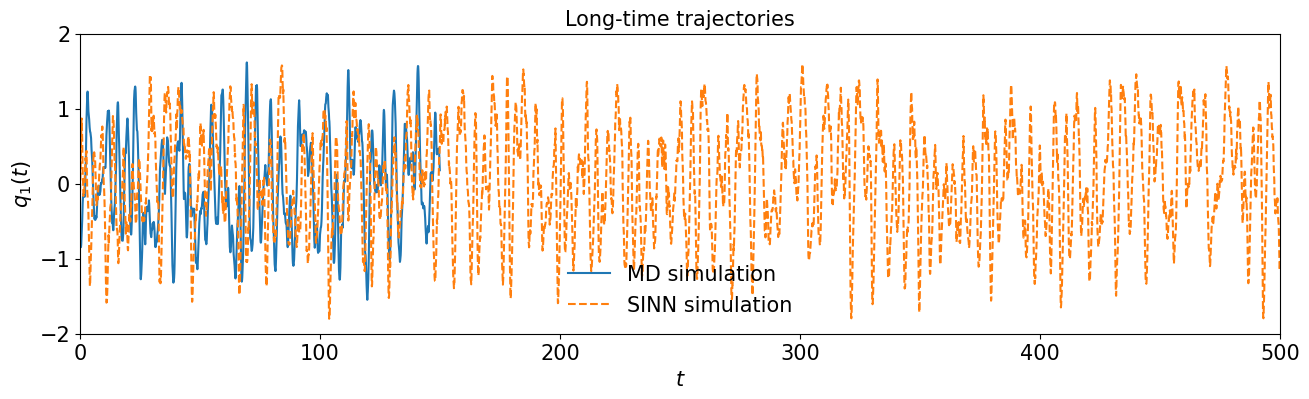

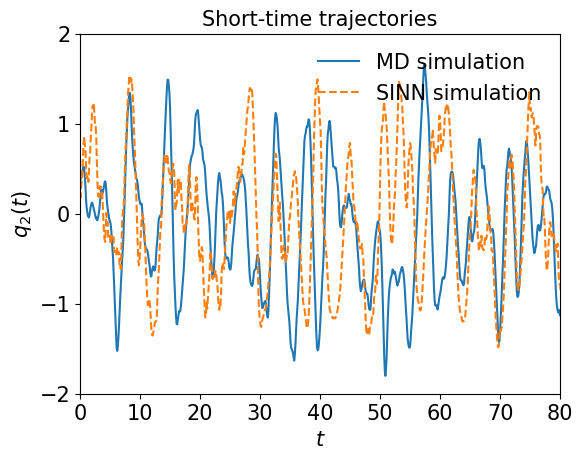

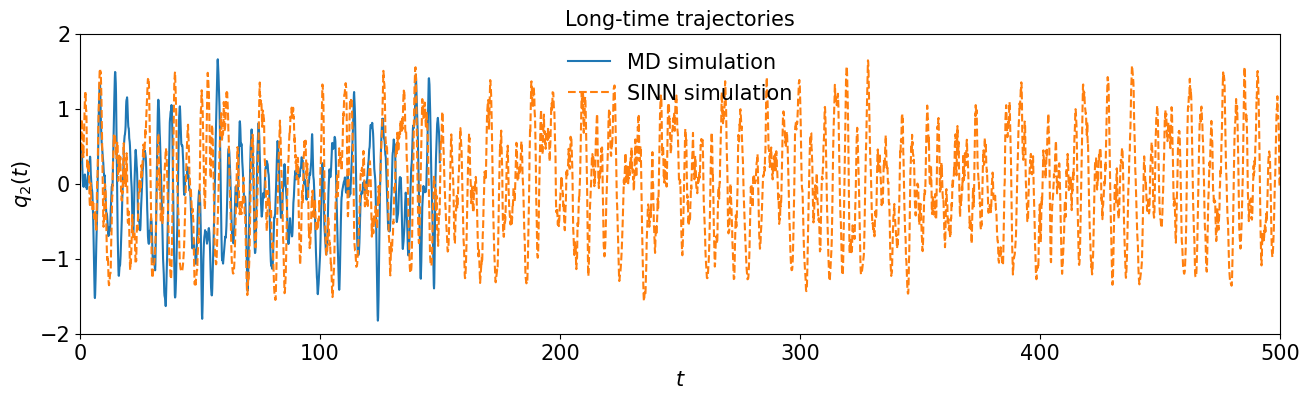

In [50]:
test5(q1_store, q2_store, net)

In [51]:
for step in range(step,20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length, batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch, 1)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = ccf/(ccf+pdf+acf_sec_moment)
            c2 = pdf/(ccf+pdf+acf_sec_moment)
            c3 = acf_sec_moment/(ccf+pdf+acf_sec_moment)
    if ccf <=0.00010 and pdf<=0.00002 and acf_sec_moment<=0.0001:
            break

if ccf > 0.0001 or pdf >0.00002 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')
print(step)

[8450]-th step loss: 0.0001, 0.0001, ccf: 0.00015, pdf: 0.00007, acf: 0.00008
[8500]-th step loss: 0.0001, 0.0001, ccf: 0.00016, pdf: 0.00006, acf: 0.00009
[8550]-th step loss: 0.0001, 0.0001, ccf: 0.00013, pdf: 0.00006, acf: 0.00008
[8600]-th step loss: 0.0001, 0.0001, ccf: 0.00012, pdf: 0.00006, acf: 0.00008
[8650]-th step loss: 0.0001, 0.0001, ccf: 0.00012, pdf: 0.00005, acf: 0.00008
[8700]-th step loss: 0.0001, 0.0001, ccf: 0.00011, pdf: 0.00005, acf: 0.00008
[8750]-th step loss: 0.0001, 0.0001, ccf: 0.00012, pdf: 0.00006, acf: 0.00008
[8800]-th step loss: 0.0001, 0.0001, ccf: 0.00011, pdf: 0.00005, acf: 0.00008
[8850]-th step loss: 0.0001, 0.0001, ccf: 0.00020, pdf: 0.00008, acf: 0.00010
[8900]-th step loss: 0.0001, 0.0001, ccf: 0.00011, pdf: 0.00007, acf: 0.00008
[8950]-th step loss: 0.0001, 0.0001, ccf: 0.00011, pdf: 0.00004, acf: 0.00008
[9000]-th step loss: 0.0001, 0.0001, ccf: 0.00011, pdf: 0.00004, acf: 0.00008
[9050]-th step loss: 0.0001, 0.0001, ccf: 0.00011, pdf: 0.00005,

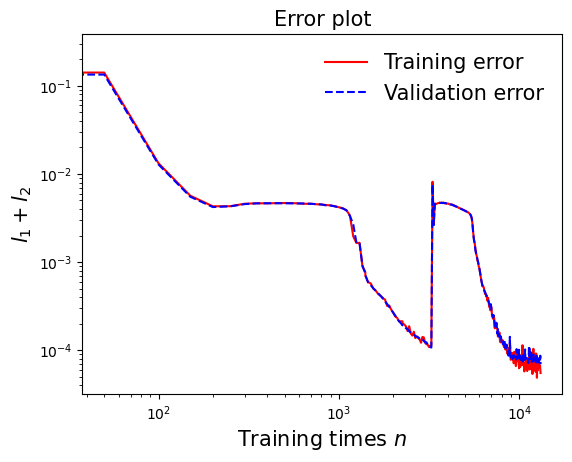

In [52]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

In [ ]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

In [ ]:
test1(Traj, T, net)

In [ ]:
test2(target, net)

In [ ]:
test3(target, net)

In [ ]:
test4(target, net)

# 2. 2 inputs

In [47]:
# Reformulating data into Torch tensors 
# Input of SINN should be of the form (seq_len, batch, input_size)

ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
input = torch.from_numpy(ini.reshape(2*sec_length, batch, 2)).to(device)
batch_validation = batch
val_set = torch.normal(0.0, 1.0, (2*sec_length, batch_validation, 2), device=device)


Traj = Traj.astype(np.float32) 
target = torch.from_numpy(Traj.reshape(sec_length, batch, 2)).to(device)
print('The torch input size is', input.size(), input.dtype)
print('The torch validation size is', val_set.size(), val_set.dtype)
print('The torch target size is', target.size(), target.dtype)

The torch input size is torch.Size([800, 400, 2]) torch.float32
The torch validation size is torch.Size([800, 400, 2]) torch.float32
The torch target size is torch.Size([400, 400, 2]) torch.float32


In [48]:
# Defining Loss functions
LAGS = 400
N = 400
loss_acf_fft = make_loss('acf[fft]', target, lags=LAGS, device=device)
loss_acf_sec_moment = make_loss('acf[fft]', target**2, lags=LAGS, device=device)
loss_acf_bruteforce = make_loss('acf[bruteforce]', target, lags=LAGS, device=device)
loss_acf_randbrute = make_loss('acf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_ccf_fft = make_loss('ccf[fft]', target, lags=LAGS, device=device)
loss_ccf_sec_moment = make_loss('ccf[fft]', target**2, lags=LAGS, device=device)
loss_ccf_bruteforce = make_loss('ccf[bruteforce]', target, lags=LAGS, device=device)
loss_ccf_randbrute = make_loss('ccf[randombrute]', target, lags=LAGS, sample_lags=20, device=device)

loss_pdf_empirical = make_loss('pdf', target, lower=-5, upper=5, n=N, bw=None, device=device)

In [49]:
### Defining SINN model
net = SINN(2, 10, 2, 2).to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-3)

In [50]:
### coefficients of loss functions
c1 = 1               # coefficient of CCF
c2 = 1              # coefficient of PDF
c3 = 1               # coefficient of ACF of second moment

In [51]:
%%time
# Training SINN
T_error=[]
V_error=[]
T_ccf=[]
V_ccf=[]
T_pdf=[]
V_pdf=[]
T_acf=[]
V_acf=[]
Step=[]
for step in range(20000):
    optimizer.zero_grad()
    ini = np.random.randn(2*sec_length,2*batch).astype(np.float32) 
    input = torch.from_numpy(ini.reshape(2*sec_length, batch,2)).to(device)
    prediction, _ = net(input)
    prediction = prediction[-LAGS:,:,:]
    loss = c1*loss_ccf_fft(prediction) + c2*loss_pdf_empirical(prediction) + c3*loss_acf_sec_moment(prediction**2)
    loss.backward()
    optimizer.step()
    if step % 50 == 0: 
        with torch.no_grad():
            pred_val, _ = net(val_set)
            pred_val = pred_val[-LAGS:,:,:]
            loss_val = c1*loss_ccf_bruteforce(pred_val)+ c2*loss_pdf_empirical(pred_val) + c3*loss_acf_sec_moment(pred_val**2)
            ccf = loss_ccf_bruteforce(pred_val)
            pdf = loss_pdf_empirical(pred_val)
            acf_sec_moment = loss_acf_sec_moment(pred_val**2)
            print('[%d]-th step loss: %.4f, %.4f, ccf: %.5f, pdf: %.5f, acf: %.5f' % (step, loss, loss_val, ccf, pdf, acf_sec_moment))
            T_ccf.append(loss_ccf_fft(prediction).detach().cpu().numpy())
            V_ccf.append(loss_ccf_bruteforce(pred_val).detach().cpu().numpy())
            T_pdf.append(loss_pdf_empirical(prediction).detach().cpu().numpy())
            V_pdf.append(loss_pdf_empirical(pred_val).detach().cpu().numpy())
            T_acf.append(loss_acf_sec_moment(prediction**2).detach().cpu().numpy())
            V_acf.append(loss_acf_sec_moment(pred_val**2).detach().cpu().numpy())
            T_error.append(loss.detach().cpu().numpy())
            V_error.append(loss_val.detach().cpu().numpy())
            Step.append(step)
            c1 = (ccf+pdf+acf_sec_moment)/ccf
            c2 = (ccf+pdf+acf_sec_moment)/pdf
            c3 = (ccf+pdf+acf_sec_moment)/acf_sec_moment
    if ccf <=0.0001 and pdf<=0.00001 and acf_sec_moment<=0.0001:
            break

if ccf > 0.0001 or pdf >0.00001 or acf_sec_moment>0.0001:
    print ('Training failed')

print('Training finished')

[0]-th step loss: 0.2591, 0.2583, ccf: 0.00370, pdf: 0.25331, acf: 0.00127
[50]-th step loss: 0.5048, 0.5100, ccf: 0.00203, pdf: 0.25020, acf: 0.00056
[100]-th step loss: 0.7095, 0.7093, ccf: 0.00213, pdf: 0.24872, acf: 0.00042
[150]-th step loss: 0.6676, 0.6577, ccf: 0.00237, pdf: 0.24413, acf: 0.00022
[200]-th step loss: 0.5926, 0.5793, ccf: 0.00285, pdf: 0.22249, acf: 0.00005
[250]-th step loss: 0.6567, 0.5989, ccf: 0.00304, pdf: 0.18957, acf: 0.00004
[300]-th step loss: 0.6261, 0.5509, ccf: 0.00328, pdf: 0.16814, acf: 0.00003
[350]-th step loss: 0.4924, 0.4895, ccf: 0.00305, pdf: 0.14944, acf: 0.00004
[400]-th step loss: 0.4739, 0.4370, ccf: 0.00279, pdf: 0.13315, acf: 0.00004
[450]-th step loss: 0.3711, 0.4035, ccf: 0.00240, pdf: 0.11527, acf: 0.00005
[500]-th step loss: 0.3376, 0.3078, ccf: 0.00213, pdf: 0.09343, acf: 0.00004
[550]-th step loss: 0.2828, 0.2644, ccf: 0.00194, pdf: 0.07311, acf: 0.00005
[600]-th step loss: 0.1969, 0.2071, ccf: 0.00189, pdf: 0.05628, acf: 0.00005
[6

[5300]-th step loss: 0.0009, 0.0008, ccf: 0.00008, pdf: 0.00009, acf: 0.00010
[5350]-th step loss: 0.0009, 0.0008, ccf: 0.00008, pdf: 0.00009, acf: 0.00010
[5400]-th step loss: 0.0009, 0.0008, ccf: 0.00008, pdf: 0.00008, acf: 0.00010
[5450]-th step loss: 0.0009, 0.0008, ccf: 0.00009, pdf: 0.00009, acf: 0.00009
[5500]-th step loss: 0.0008, 0.0008, ccf: 0.00008, pdf: 0.00008, acf: 0.00010
[5550]-th step loss: 0.0009, 0.0007, ccf: 0.00007, pdf: 0.00007, acf: 0.00010
[5600]-th step loss: 0.0008, 0.0007, ccf: 0.00009, pdf: 0.00007, acf: 0.00008
[5650]-th step loss: 0.0008, 0.0007, ccf: 0.00007, pdf: 0.00006, acf: 0.00010
[5700]-th step loss: 0.0007, 0.0007, ccf: 0.00006, pdf: 0.00006, acf: 0.00010
[5750]-th step loss: 0.0008, 0.0007, ccf: 0.00006, pdf: 0.00006, acf: 0.00010
[5800]-th step loss: 0.0007, 0.0007, ccf: 0.00007, pdf: 0.00005, acf: 0.00010
[5850]-th step loss: 0.0007, 0.0006, ccf: 0.00006, pdf: 0.00005, acf: 0.00010
[5900]-th step loss: 0.0007, 0.0007, ccf: 0.00006, pdf: 0.00005,

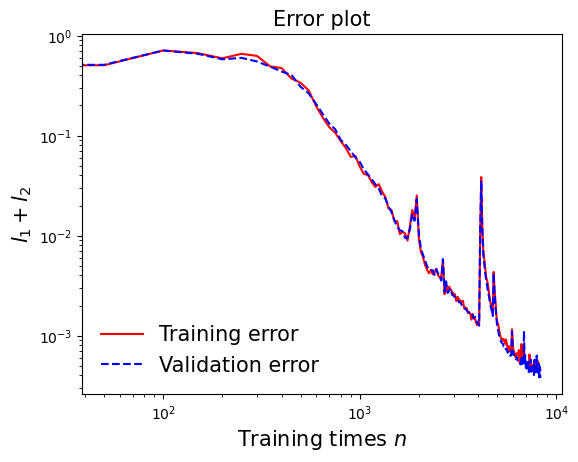

In [52]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot",fontsize=15) 
plt.loglog(Step, T_error,'r',label='Training error')
plt.loglog(Step, V_error,'b--',label='Validation error')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15)

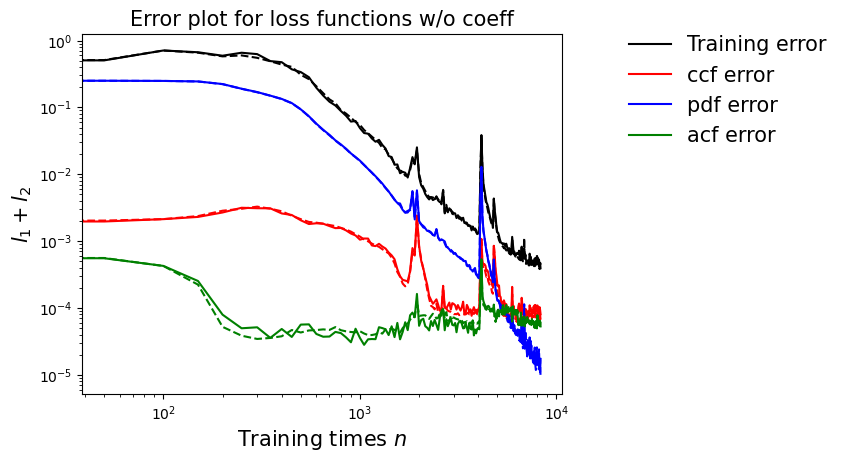

In [53]:
### Plotting the training and the generalization error
fig = plt.figure(1)
ax = fig.add_axes([0.15, 0.15, 0.75, 0.75])
plt.title("Error plot for loss functions w/o coeff",fontsize=15) 
plt.loglog(Step, T_error,'k',label='Training error')
plt.loglog(Step, V_error,'k--')
plt.loglog(Step, T_ccf,'r',label='ccf error')
plt.loglog(Step, V_ccf,'r--')
plt.loglog(Step, T_pdf,'b',label='pdf error')
plt.loglog(Step, V_pdf,'b--')
plt.loglog(Step, T_acf,'g',label='acf error')
plt.loglog(Step, V_acf,'g--')
plt.xlabel(r'Training times $n$',fontsize=15)
plt.ylabel(r'$l_1+l_2$',fontsize=15)
plt.legend(frameon=False,fontsize=15, bbox_to_anchor=(1.1, 1.05))

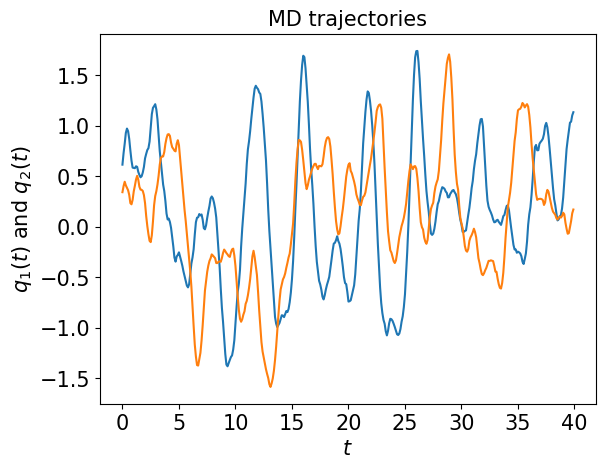

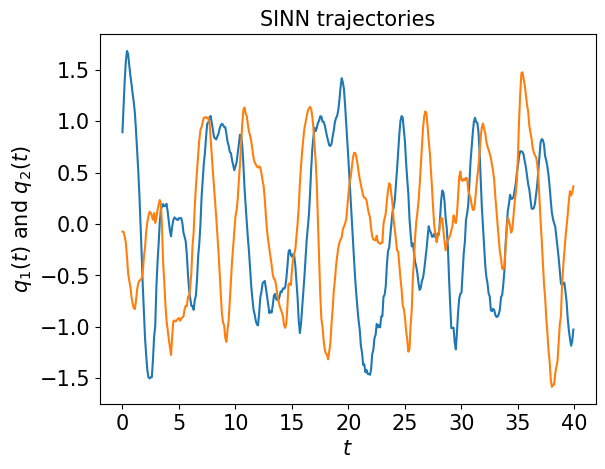

In [54]:
test1(Traj, T, net)

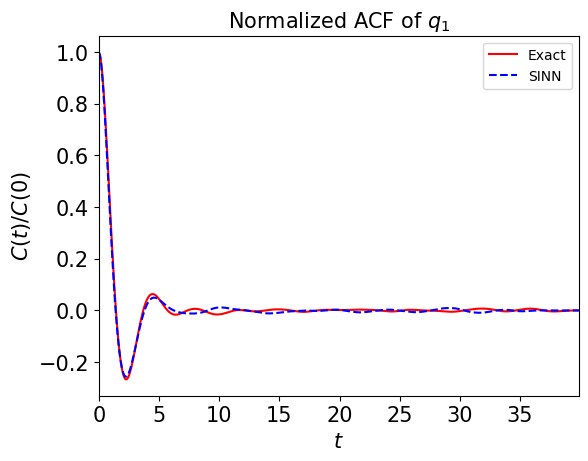

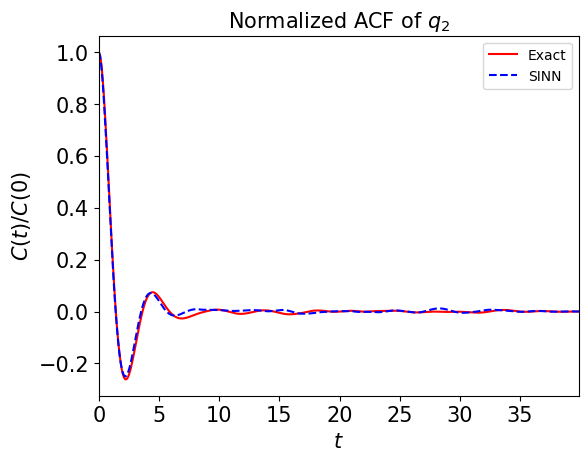

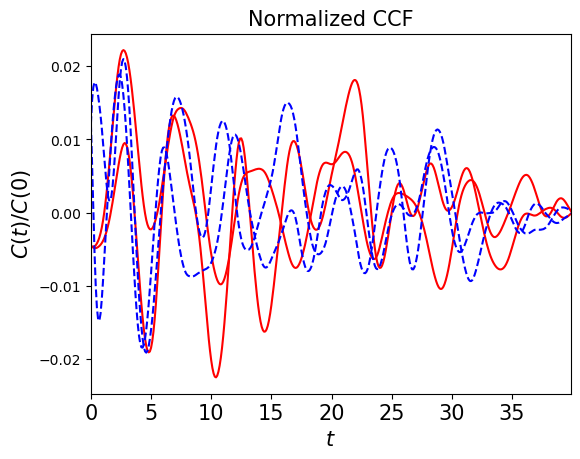

In [55]:
test2(target, net)

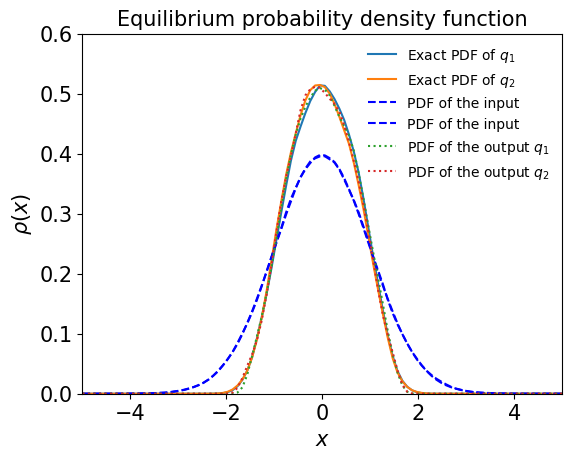

In [56]:
test3(target, net)

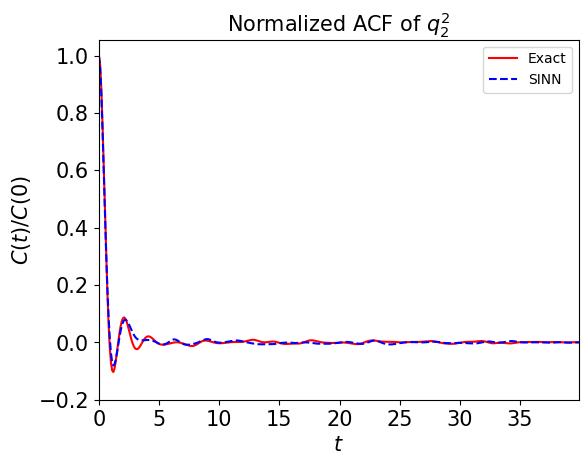

In [57]:
test4(target, net)

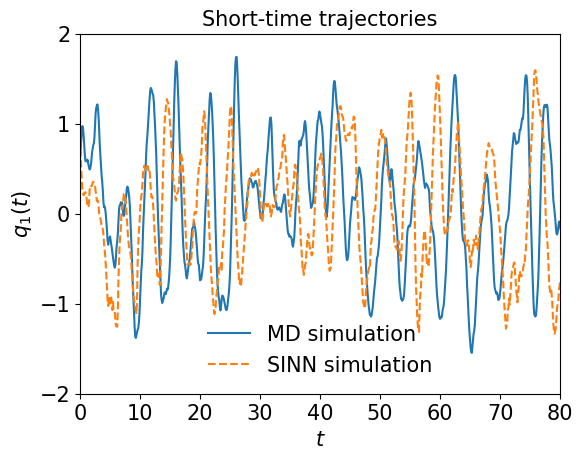

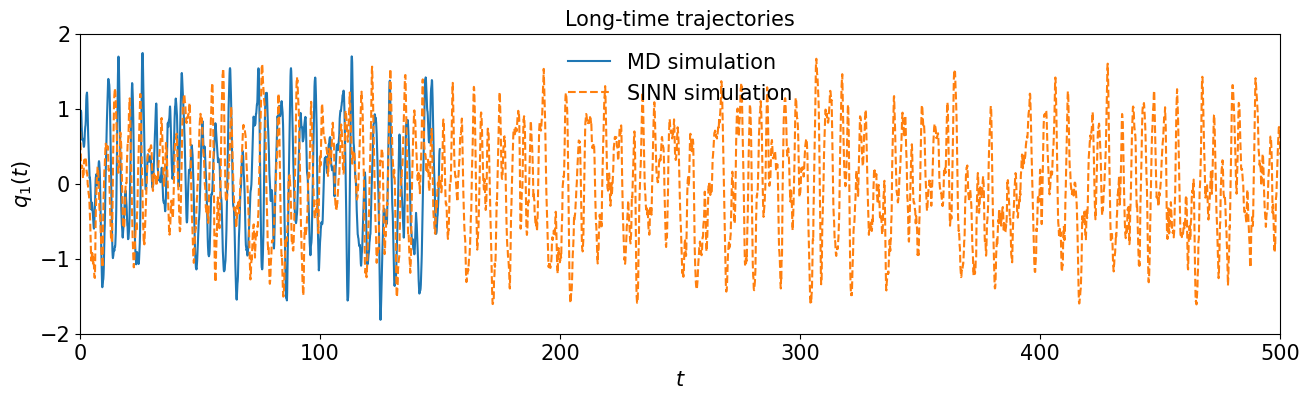

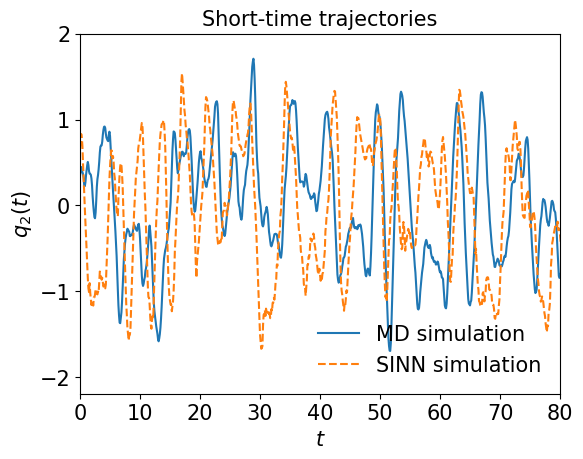

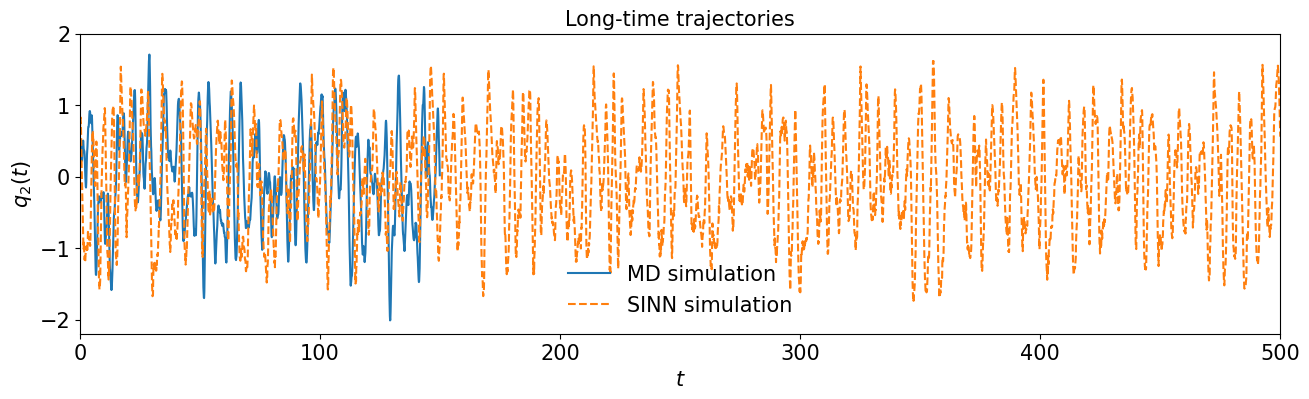

In [58]:
test5(q1_store, q2_store, net)